## Some plots for the Dynamic Foraging White Book

Han Hou 02/2025

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from aind_analysis_arch_result_access.han_pipeline import get_session_table
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Get the master session table

In [3]:
df = get_session_table()
len(df)

6838

## Session count grouped by curriculum over time

In [4]:
df_curriculum = df[['subject_id', 'session_date', 'session', 'curriculum_name', 'curriculum_version', 'current_stage_actual']]

In [5]:
def plot_session_counts_over_time(
    df,
    time_bin="D",
    bar_width=0.8,
    group_by="curriculum_name",
    group_rename=None,
    group_custom_order=None,
    group_custom_color=None,
    ax=None,
):
    """Plot the number of sessions over time, grouped by a specified column.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing the session data. Must contain 'session_date' and the column specified by group_by.
    time_bin : str, optional
        Resampling frequency for the x-axis. See pandas resample for options, by default "D"
    bar_width : float, optional
        Width of the bars in the bar chart, by default 0.8
    group_by : str, optional
        Column name to group by. Must be present in the DataFrame, by default "curriculum_name"
    group_rename : _type_, optional
        rename the groups of the unique values of the group_by column, by default None
    group_custom_order : _type_, optional
        custom order of the groups of the unique values of the group_by column, by default None
    group_custom_color : _type_, optional
        custom color of the groups of the unique values of the group_by column, by default None
    ax : _type_, optional
        _description_, by default None

    Returns
    -------
    _type_
        _description_
    """
    # Count number of sessions per day per type
    session_counts = (
        df.groupby([pd.Grouper(key="session_date", freq=time_bin), group_by])
        .size()
        .unstack(fill_value=0)
    )
    if group_rename is not None:
        session_counts = session_counts.rename(columns=group_rename)
    if group_custom_order is not None:
        session_counts = session_counts[group_custom_order]

    # Plot stacked bar chart
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))
    session_counts.plot(
        kind="bar",
        stacked=True,
        ax=ax,
        width=bar_width,
        **({} if group_custom_color is None else {"color": group_custom_color}),
    )
    ax.set_xlabel("Date")
    ax.set_ylabel("Number of sessions")
    ax.legend(title=group_by)

    # Format x-axis to show only year and month
    ax.set_xticks([])  # Hide all default x-ticks
    ax.set_xticks(
        range(len(session_counts),0, -max(1, len(session_counts) // 10))
    )  # Set sparse ticks
    ax.set_xticklabels(
        session_counts.index[:: -max(1, len(session_counts) // 10)].strftime("%Y-%m"),
        rotation=45,
    )
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # Rotate x axix ticks
    ax.tick_params(axis="x", rotation=45)
    return ax

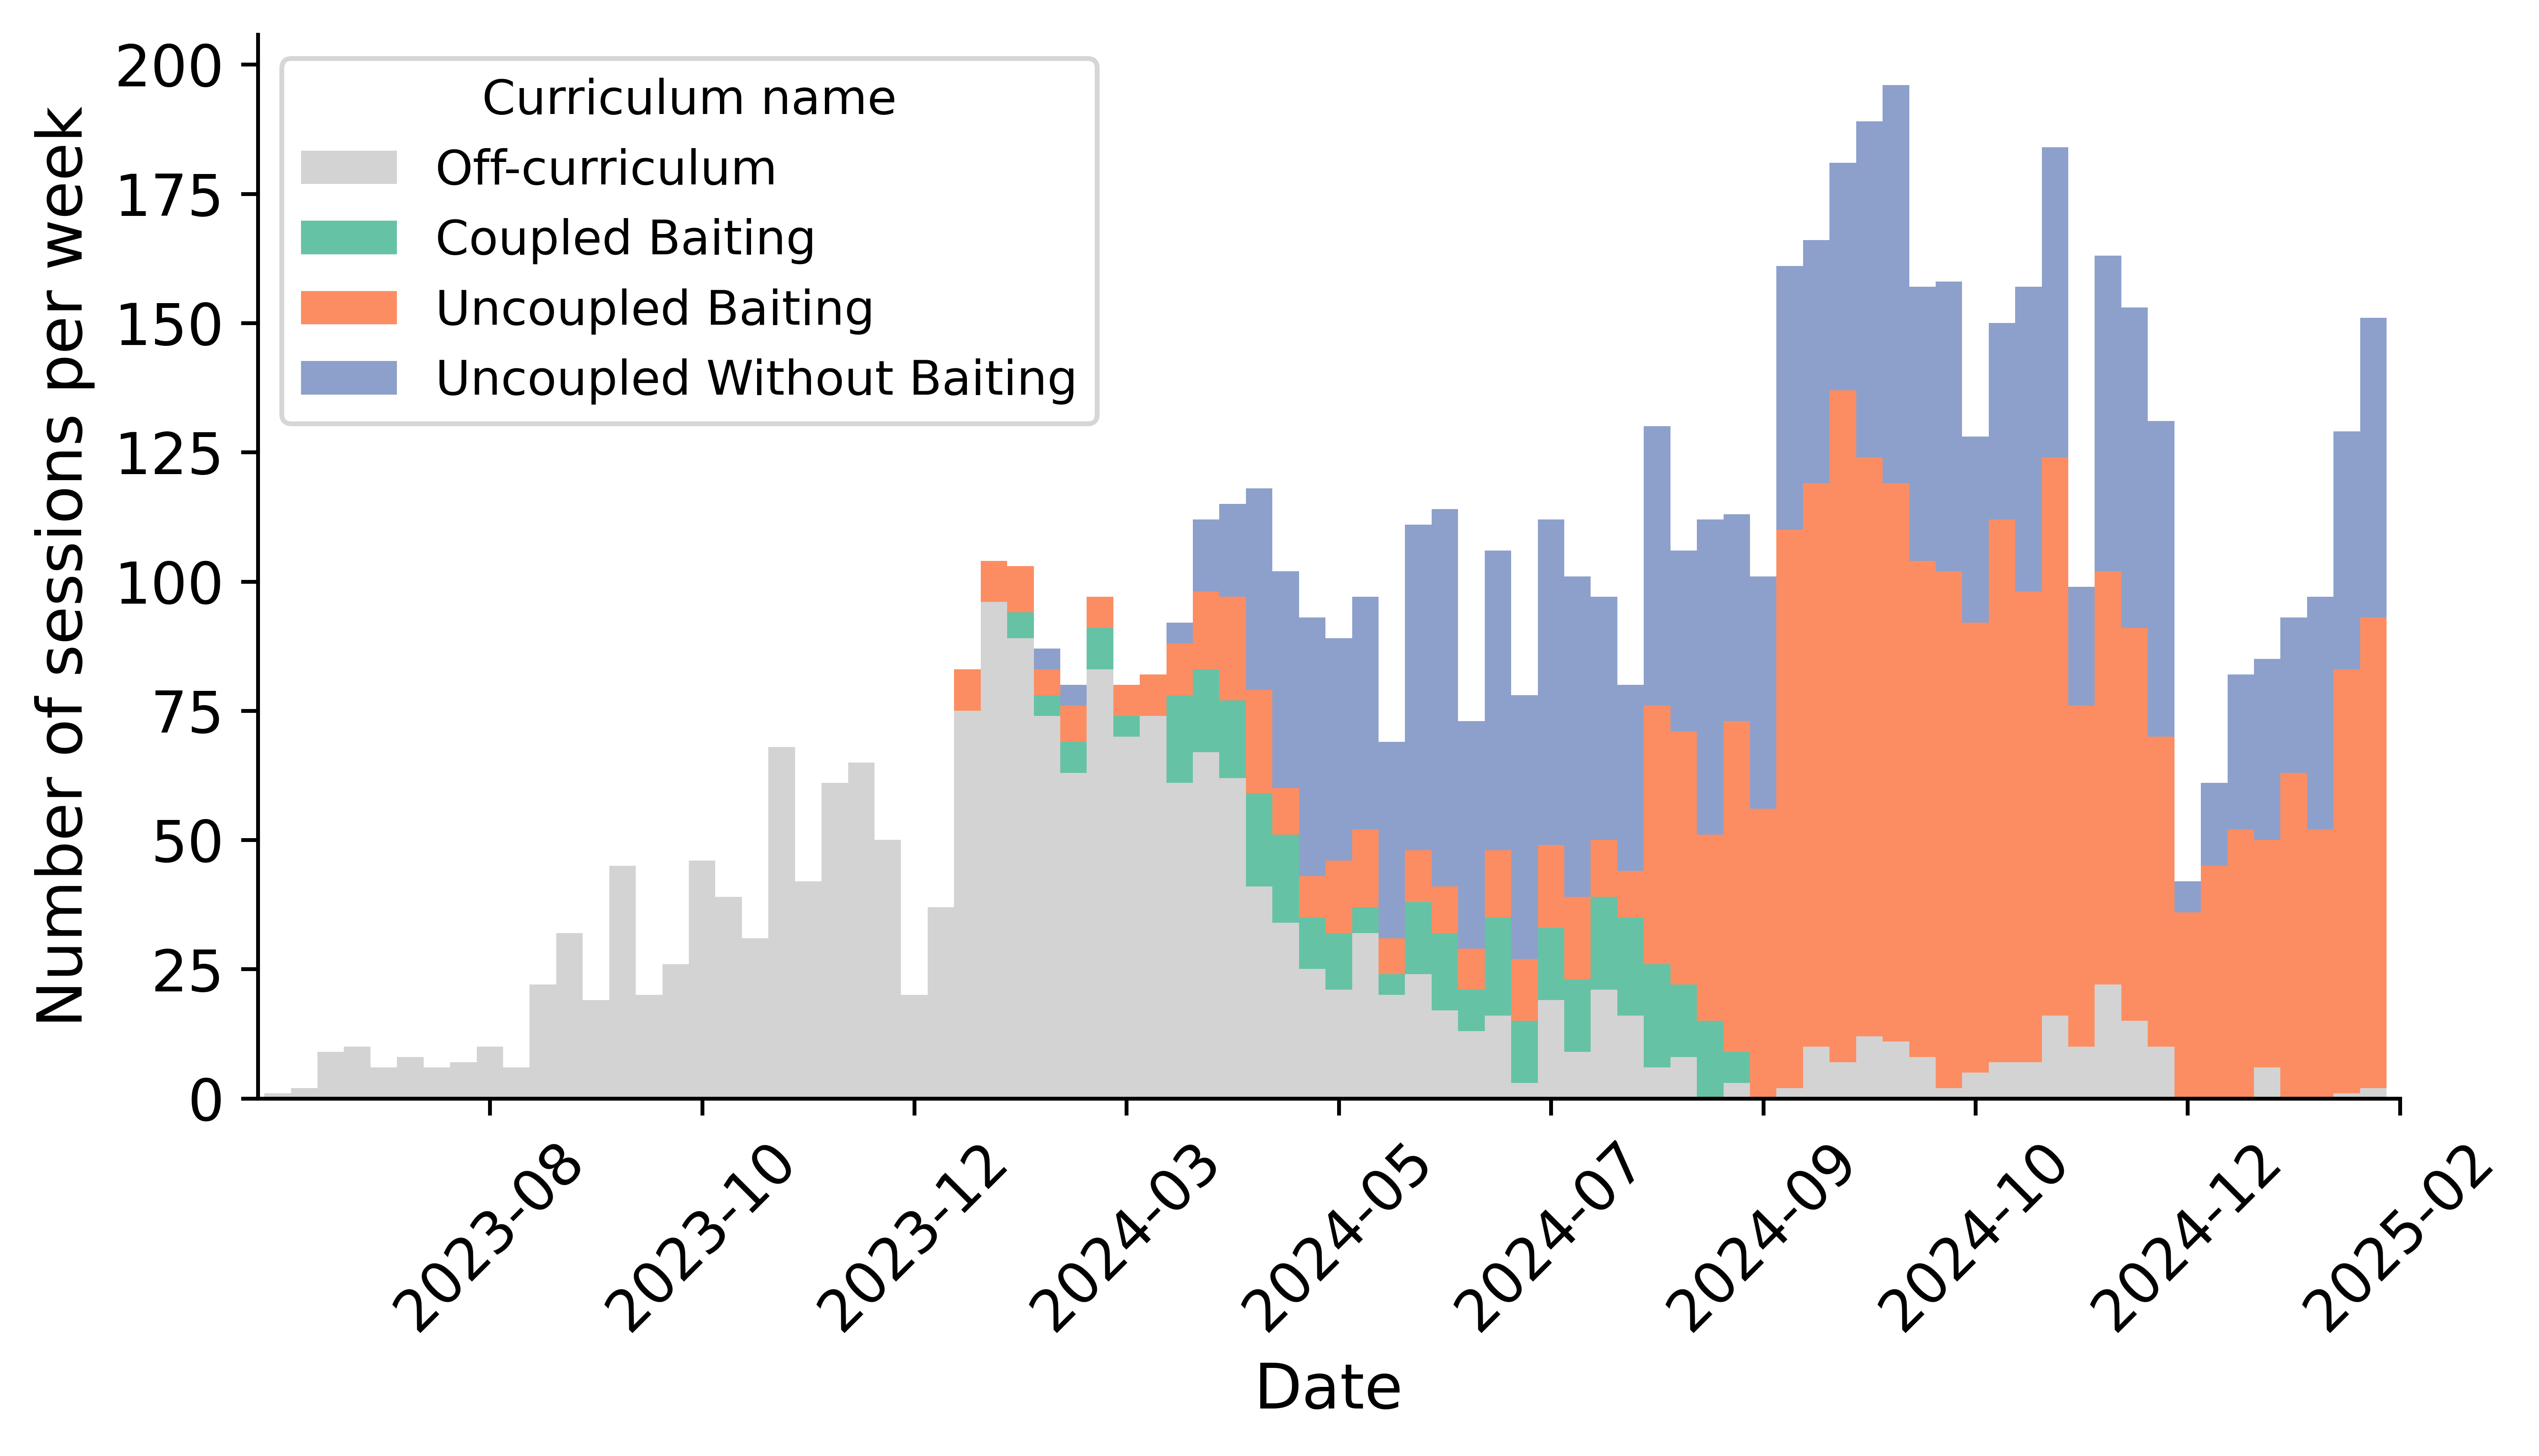

In [6]:
import matplotlib
import matplotlib.colors as mcolors
plt.rcParams.update({'font.size': 12})

# Get colors from the "Set2" colormap
colormap = matplotlib.colormaps["Set2"]

# Display the plot
fig, ax = plt.subplots(figsize=(8, 4), dpi=800)
ax = plot_session_counts_over_time(
    df_curriculum,
    time_bin="W",
    bar_width=1,
    group_rename={
        "Coupled Baiting": "Coupled Baiting",
        "Uncoupled Baiting": "Uncoupled Baiting",
        "Uncoupled Without Baiting": "Uncoupled Without Baiting",
        "None": "Off-curriculum",
    },
    group_custom_order=["Off-curriculum", "Coupled Baiting", "Uncoupled Baiting", "Uncoupled Without Baiting"],
    group_custom_color=["lightgray"] + [colormap(i) for i in range(3)],
    ax=ax,
)

# set axis title font size
ax.set_xlabel("Date", fontsize=13)
ax.set_ylabel("Number of sessions per week", fontsize=13)

# set legend title font size
ax.legend(title="Curriculum name", title_fontsize=10, fontsize=10)

# save svg
fig.savefig("session_counts_by_curriculum_name_over_time.svg", bbox_inches="tight")


## Autotrain trajectory and distribution

In [7]:
df_curriculum_on_only = df_curriculum.query('curriculum_name != "None" and curriculum_version != "0.1"').copy()
len(df_curriculum_on_only)

4823

In [8]:
# Manually group curriculum versions (ver < 2.0, 2.0 <= ver < 2.3, ver >=2.3)
def _map_curriculum_ver(ver):
    if "2.3" in ver:
        return "v3"
    elif "1.0" in ver:
        return "v1"
    else:
        return "v2"

df_curriculum_on_only["curriculum_version_group"] = df_curriculum_on_only["curriculum_version"].map(_map_curriculum_ver)

In [9]:
if_graduated_only = False

if if_graduated_only:
    df_curriculum_on_only = df_curriculum_on_only.groupby("subject_id").filter(lambda x: "GRADUATED" in x["current_stage_actual"].values)

In [10]:
len(df_curriculum_on_only.subject_id.unique())

238

### Stage progression trajectory

In [11]:
stage_order = [
    "STAGE_1_WARMUP",
    "STAGE_1",
    "STAGE_2",
    "STAGE_3",
    "STAGE_4",
    "STAGE_FINAL",
    "GRADUATED",
]

def get_stage_color_mapper(stage_list):
    # Mapping stages to colors from red to green, return rgb values
    # Interpolate between red and green using the number of stages
    cmap = matplotlib.colormaps['RdYlGn']
    stage_color_mapper = {
        stage: matplotlib.colors.rgb2hex(
            cmap(i / (len(stage_list) - 1))) 
        for i, stage in enumerate(stage_list)
    }
    stage_color_mapper.update({"STAGE_3": "#ecedab"})  # Better contrast
    return stage_color_mapper

stage_color_mapper = get_stage_color_mapper(stage_order)

In [12]:
def plot_stage_progression(
    df,
    subject_ids_highlight=[],
    color="black",
    if_highlight_graduated=True,
    min_dropout_session=25,
    ax=None,
):
    """Plot the stage progression of each mouse over time.
        Parameters
        ----------
        df : pd.DataFrame
            DataFrame containing the session data. Must contain 'session_date', 'session', and 'current_stage_y'.
        subject_ids_highlight : list, optional
            List of subject IDs to highlight, by default []
        color : str, optional
            Color for the lines, by default "black"
        if_highlight_graduated : bool, optional
            If True, highlight the first graduated stage of each mouse using green, and the 
            last session of mice who failed to graduated within min_dropout_session using red 
            (dropped out), by default True
        min_dropout_session : int, optional
            Minimum number of sessions to consider a mouse as dropped out, by default 25
        ax : matplotlib.axes.Axes, optional
            Axes
    """
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 2), dpi=500)

    all_mice = df["subject_id"].unique()

    # put highlight mice at the last
    subject_ids = [
        subject_id for subject_id in all_mice if subject_id not in subject_ids_highlight
    ] + subject_ids_highlight
    
    h_dropped_out, h_graduated = None, None

    for subject_id in subject_ids:
        subject_df = df.query("subject_id == @subject_id")
        subject_df = subject_df.sort_values(by="session_date")

        x = subject_df["session"] + np.random.normal(0, 0.1, len(subject_df))
        y = subject_df["current_stage_y"] + np.random.normal(0, 0.1, len(subject_df))

        # add a random small jitter
        ax.plot(
            x,
            y,
            label=subject_id,
            alpha=0.5 if subject_id not in subject_ids_highlight else 1,
            color=color if subject_id not in subject_ids_highlight else "red",
            linewidth=0.2 if subject_id not in subject_ids_highlight else 1,
        )

        # If if highlight_graduated is True, highlight the first graduated stage of each mouse using green,
        # and the last session of mice who failed to graduated using red (dropped out)
        if if_highlight_graduated:
            graduated_sessions = subject_df.query("current_stage_actual == 'GRADUATED'").session
            if graduated_sessions.size > 0:
                first_graduated_idx = graduated_sessions.idxmin()
                h_graduated = ax.scatter(
                    x[first_graduated_idx],
                    y[first_graduated_idx],
                    color="green",
                    marker="o",
                    s=30,
                    alpha=0.7,
                    label="First graduated session"
                )
            elif len(subject_df) > min_dropout_session:
                h_dropped_out = ax.scatter(
                    x.iloc[-1],
                    y.iloc[-1],
                    color="red",
                    marker="x",
                    s=30,
                    alpha=0.7,
                    label=f"Failed to graduate\nafter {min_dropout_session} sessions",
                )

    ax.set(
        xlabel="Session",
        yticks=range(len(df.current_stage_actual.unique())),
        yticklabels=[stage for stage in stage_order if stage in df.current_stage_actual.unique()],
        ylim=(-0.5, 6.5),
    )
    return ax, h_dropped_out, h_graduated

In [37]:
curriculum_name_order = ["Coupled Baiting", "Uncoupled Without Baiting", "Uncoupled Baiting"]
ver_order = ["v1", "v2", "v3"]

colormap = matplotlib.colormaps["Set2"]

fig, ax = plt.subplots(3, 3, figsize=(22, 15), dpi=500, gridspec_kw={'hspace': 0.5, 'wspace': 1})

graduated_str = " , GRADUATED only" if if_graduated_only else ""

for i, curriculum in enumerate(curriculum_name_order):
    for j, ver in enumerate(ver_order):   
        this_ax = ax[i, j]
        df_this = df_curriculum_on_only.query("curriculum_name == @curriculum and curriculum_version_group == @ver").copy()

        # Add current_stage_y for each curriculum
        all_unique_stages = [stage for stage in stage_order if stage in df_this["current_stage_actual"].unique()]
        df_this["current_stage_y"] = df_this["current_stage_actual"].map(lambda x: all_unique_stages.index(x))

        # -- density plot for each curriculum in the background--
        sns.histplot(
            df_this,
            x="session",
            y="current_stage_y",
            color=colormap(i),
            bins=(np.arange(-0.5, df_this["session"].max() + 1, 1), np.arange(-0.5, df_this["current_stage_y"].max() + 1, 1)),
            ax=this_ax,
            stat="density",
            cbar=False,
        )
        
        # -- plot the stage progression for each curriculum --
        _, h_dropped_out, h_graduated = plot_stage_progression(
            df_this,
            subject_ids_highlight=[],
            ax=this_ax,
        )

        this_ax.set(
            xlim=(0, 40),
            ylabel="",
        )
        this_ax.set_title(
            label=f"{curriculum} {ver} ({len(df_this.subject_id.unique())} mice, {len(df_this)} sessions{graduated_str})",
            pad=20,
        )
        
        # Add legend
        if i == 1 and j == 1:
            this_ax.legend(
                handles=[h_dropped_out, h_graduated],
                fontsize=8,
                loc="lower right",
            )

sns.despine(offset=10, trim=True)
# fig.tight_layout()
plt.show()

### Distributions of first entry and last leave

In [14]:
df_stats = df_curriculum_on_only.groupby(["subject_id", "current_stage_actual"], sort=False)[
    "session"
].agg(
    [
        ("session_spent", "count"),  # Number of sessions spent at this stage
        # First entry to this stage
        ("first_entry", "min"),
        # Last leave from this stage
        ("last_leave", "max"),
    ]
)

df_stats["session_spanned"] = df_stats.last_leave - df_stats.first_entry + 1

df_stats = df_stats.reset_index().sort_values(["subject_id", "last_leave"])

# Merge in curriculum name and version name
df_stats = df_stats.merge(df_curriculum_on_only[["subject_id", "curriculum_name", "curriculum_version_group",
                                                 ]].drop_duplicates(), on="subject_id", how="left")

# Melt first_entry and last_leave
df_stats_melt = df_stats.melt(
    id_vars=[
        "subject_id",
        "current_stage_actual",
        "curriculum_name",
        "curriculum_version_group",
    ],
    value_vars=["first_entry", "last_leave"],
    var_name="type",
    value_name="session",
)

# Remove first entry of STAGE_1_WARMUP and last leave of GRADUATED
df_stats_melt = df_stats_melt.query(
    "not (current_stage_actual == 'STAGE_1_WARMUP' and type == 'first_entry') and not (current_stage_actual == 'GRADUATED' and type == 'last_leave')"
)

In [15]:
df_stats

subject_id current_stage_actual  session_spent  first_entry  last_leave  \
0        690486              STAGE_3              2          6.0         8.0   
1        690486          STAGE_FINAL              2          7.0         9.0   
2        690494              STAGE_1              1          9.0         9.0   
3        690494              STAGE_2              3          7.0        10.0   
4        697929              STAGE_2              1          3.0         3.0   
...         ...                  ...            ...          ...         ...   
1323     781471       STAGE_1_WARMUP              1          1.0         1.0   
1324     781471              STAGE_1              2          2.0         3.0   
1325     781471              STAGE_2              2          4.0         5.0   
1326     781471              STAGE_3              2          6.0        11.0   
1327     781471          STAGE_FINAL              8          7.0        15.0   

      session_spanned            curriculum_name curriculum_version_group  
0                 3.0  Uncoupled Without Baiting                       v1  
1                 3.0  Uncoupled Without Baiting                       v1  
2                 1.0  Uncoupled Without Baiting                       v1  
3                 4.0  Uncoupled Without Baiting                       v1  
4                 1.0            Coupled Baiting                       v1  
...               ...                        ...                      ...  
1323              1.0  Uncoupled Without Baiting                       v3  
1324              2.0  Uncoupled Without Baiting                       v3  
1325              2.0  Uncoupled Without Baiting                       v3  
1326              6.0  Uncoupled Without Baiting                       v3  
1327              9.0  Uncoupled Without Baiting                       v3  

[1328 rows x 8 columns]

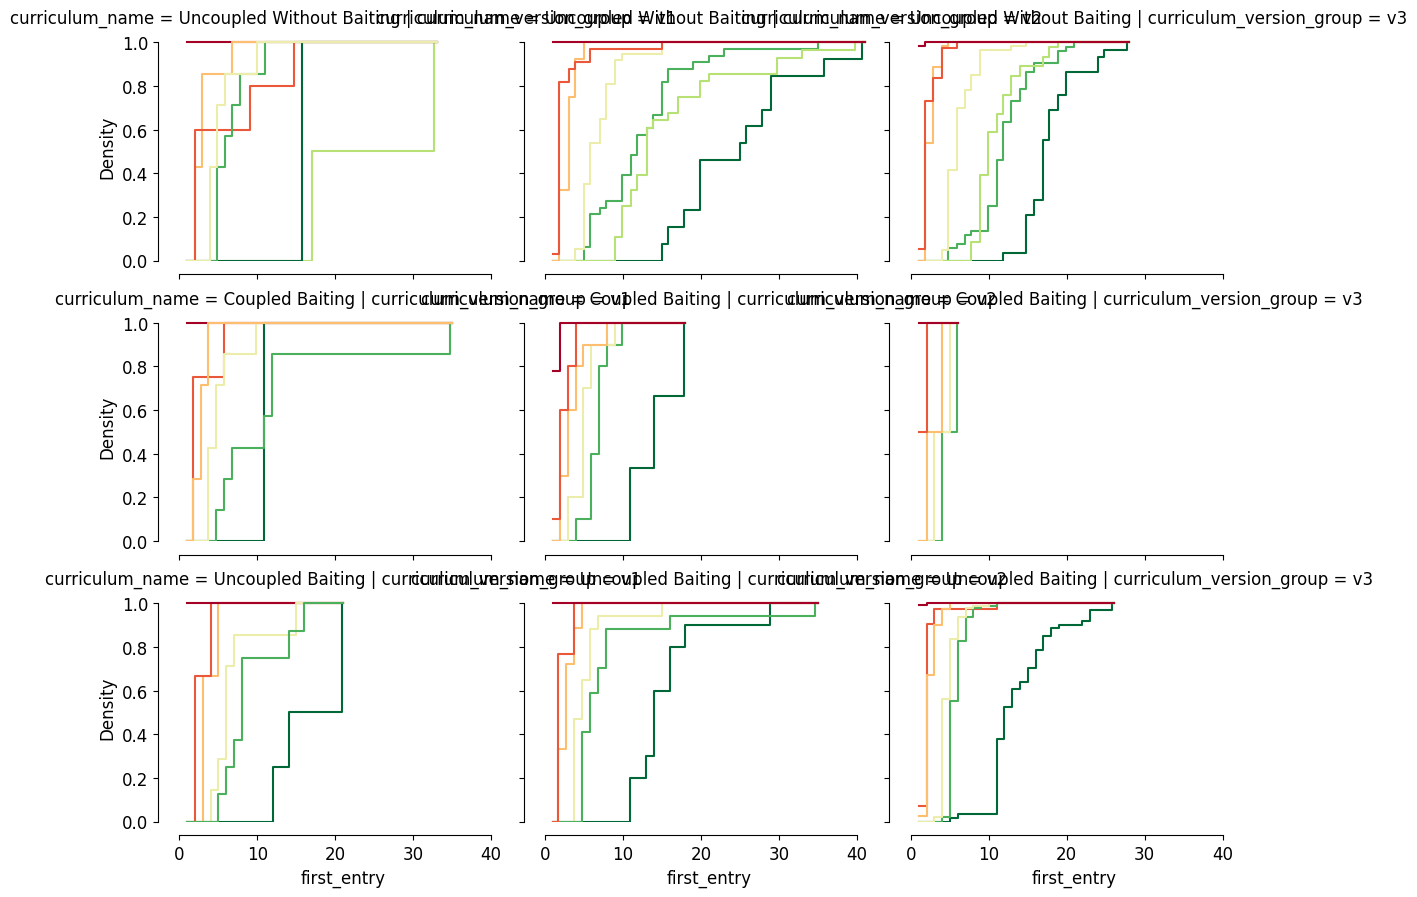

In [16]:
to_plot = "first_entry"

# Set up the FacetGrid for vertical subplots
g = sns.FacetGrid(
    df_stats,
    col="curriculum_version_group",
    row="curriculum_name",
    col_order=ver_order,
    # col_wrap=len(ver_order),
    height=3,
    aspect=1.3,
    sharex=True,
    sharey=True,
    despine=True,
)

# Map the histogram to the FacetGrid
g.map_dataframe(
    sns.histplot,
    x=to_plot,
    hue="current_stage_actual",
    palette=stage_color_mapper,
    element="step",
    fill=False,
    cumulative=True,
    bins=100,
    stat="density",
    common_norm=False,
    legend=True,
)

# for ax in g.axes.flat:
#     ax.set_facecolor('silver')
            
# Adjust layout
sns.despine(offset=10, trim=True)
fig = g.fig
# plt.tight_layout()
plt.show()

### For a certain curriculum group, plot cumulative GRADUATED mice over session

In [17]:
df_curriculum_on_only = df_curriculum.query('curriculum_name != "None" and curriculum_version != "0.1"').copy()

In [18]:
df_curriculum_on_only.curriculum_version.unique()

array(['2.3', '2.3.1rwdDelay159', '2.3rwdDelay159', '2.2.1rwdDelay159',
       '2.2', '1.0', '2.2rwdDelay159', '2.1rwdDelay159', '2.0', '2.1'],
      dtype=object)

In [19]:
# Manually group curriculum versions (ver < 2.0, 2.0 <= ver < 2.3, ver >=2.3)
def _map_curriculum_ver(ver):
    if "2.3" in ver:
        return "v3"
    elif "1.0" in ver:
        return "v1"
    else:
        return "v2"

df_curriculum_on_only["curriculum_version_group"] = df_curriculum_on_only["curriculum_version"].map(_map_curriculum_ver)

In [20]:
df_curriculum_on_only

subject_id session_date  session            curriculum_name  \
0        765062   2025-02-16      7.0          Uncoupled Baiting   
1        753618   2025-02-16      7.0          Uncoupled Baiting   
2        770772   2025-02-16     13.0          Uncoupled Baiting   
3        763704   2025-02-16     14.0          Uncoupled Baiting   
4        769253   2025-02-16     13.0          Uncoupled Baiting   
...         ...          ...      ...                        ...   
5810     702200   2024-02-29      4.0            Coupled Baiting   
5811     697929   2024-02-29      3.0            Coupled Baiting   
5812     703548   2024-02-29     14.0          Uncoupled Baiting   
5817     690486   2024-02-28      6.0  Uncoupled Without Baiting   
5818     690494   2024-02-28      7.0  Uncoupled Without Baiting   

     curriculum_version current_stage_actual curriculum_version_group  
0                   2.3          STAGE_FINAL                       v3  
1                   2.3          STAGE_FINAL                       v3  
2                   2.3          STAGE_FINAL                       v3  
3                   2.3          STAGE_FINAL                       v3  
4                   2.3          STAGE_FINAL                       v3  
...                 ...                  ...                      ...  
5810                1.0              STAGE_2                       v1  
5811                1.0              STAGE_2                       v1  
5812                1.0          STAGE_FINAL                       v1  
5817                1.0              STAGE_3                       v1  
5818                1.0              STAGE_2                       v1  

[4823 rows x 7 columns]

In [21]:
# Step 1: Find the first session where each subject graduated
graduation_sessions = df_curriculum_on_only.loc[df_curriculum_on_only["current_stage_actual"] == "GRADUATED", ["subject_id", "session"]]
graduated_subjects = graduation_sessions.groupby("subject_id")["session"].min().to_dict()

df_curriculum_on_only["cumulative_graduated"] = df_curriculum_on_only.apply(
    lambda row: graduated_subjects.get(row["subject_id"], float('inf')) <= row["session"],
    axis=1
)

In [22]:
df_curriculum_on_only

subject_id session_date  session            curriculum_name  \
0        765062   2025-02-16      7.0          Uncoupled Baiting   
1        753618   2025-02-16      7.0          Uncoupled Baiting   
2        770772   2025-02-16     13.0          Uncoupled Baiting   
3        763704   2025-02-16     14.0          Uncoupled Baiting   
4        769253   2025-02-16     13.0          Uncoupled Baiting   
...         ...          ...      ...                        ...   
5810     702200   2024-02-29      4.0            Coupled Baiting   
5811     697929   2024-02-29      3.0            Coupled Baiting   
5812     703548   2024-02-29     14.0          Uncoupled Baiting   
5817     690486   2024-02-28      6.0  Uncoupled Without Baiting   
5818     690494   2024-02-28      7.0  Uncoupled Without Baiting   

     curriculum_version current_stage_actual curriculum_version_group  \
0                   2.3          STAGE_FINAL                       v3   
1                   2.3          STAGE_FINAL                       v3   
2                   2.3          STAGE_FINAL                       v3   
3                   2.3          STAGE_FINAL                       v3   
4                   2.3          STAGE_FINAL                       v3   
...                 ...                  ...                      ...   
5810                1.0              STAGE_2                       v1   
5811                1.0              STAGE_2                       v1   
5812                1.0          STAGE_FINAL                       v1   
5817                1.0              STAGE_3                       v1   
5818                1.0              STAGE_2                       v1   

      cumulative_graduated  
0                    False  
1                    False  
2                    False  
3                    False  
4                    False  
...                    ...  
5810                 False  
5811                 False  
5812                 False  
5817                 False  
5818                 False  

[4823 rows x 8 columns]

In [23]:
def compute_cumulative_graduation_rate(df):
    # Step 1: Create a DataFrame with the graduation session for each subject
    graduated_subjects = df[df['current_stage_actual'] == 'GRADUATED']
    graduation_df = graduated_subjects.groupby('subject_id')['session'].min().reset_index()
    graduation_df.rename(columns={'session': 'graduation_session'}, inplace=True)

    # Step 2: Merge with all subjects to include curriculum version group and graduation status
    all_subjects = df[['subject_id', 'curriculum_version_group']].drop_duplicates()
    merged = all_subjects.merge(graduation_df, on='subject_id', how='left')

    # Step 3: Compute the proportion graduated for each session in each curriculum version group
    results = []

    for group in merged['curriculum_version_group'].unique():
        group_data = merged[merged['curriculum_version_group'] == group].copy()
        total_subjects = len(group_data)
        
        if total_subjects == 0:
            continue
        
        # Get the maximum session in the original data for this group
        max_session = df[df['curriculum_version_group'] == group]['session'].max()
        if pd.isna(max_session):
            continue
        max_session = int(max_session)
        
        # Iterate through each session from 1 to max_session
        for session in range(1, max_session + 1):
            count = group_data[group_data['graduation_session'] <= session]['subject_id'].count()
            proportion = count / total_subjects
            results.append({
                'curriculum_version_group': group,
                'session': session,
                'proportion_graduated': proportion
            })

    # Create the result DataFrame
    return pd.DataFrame(results)

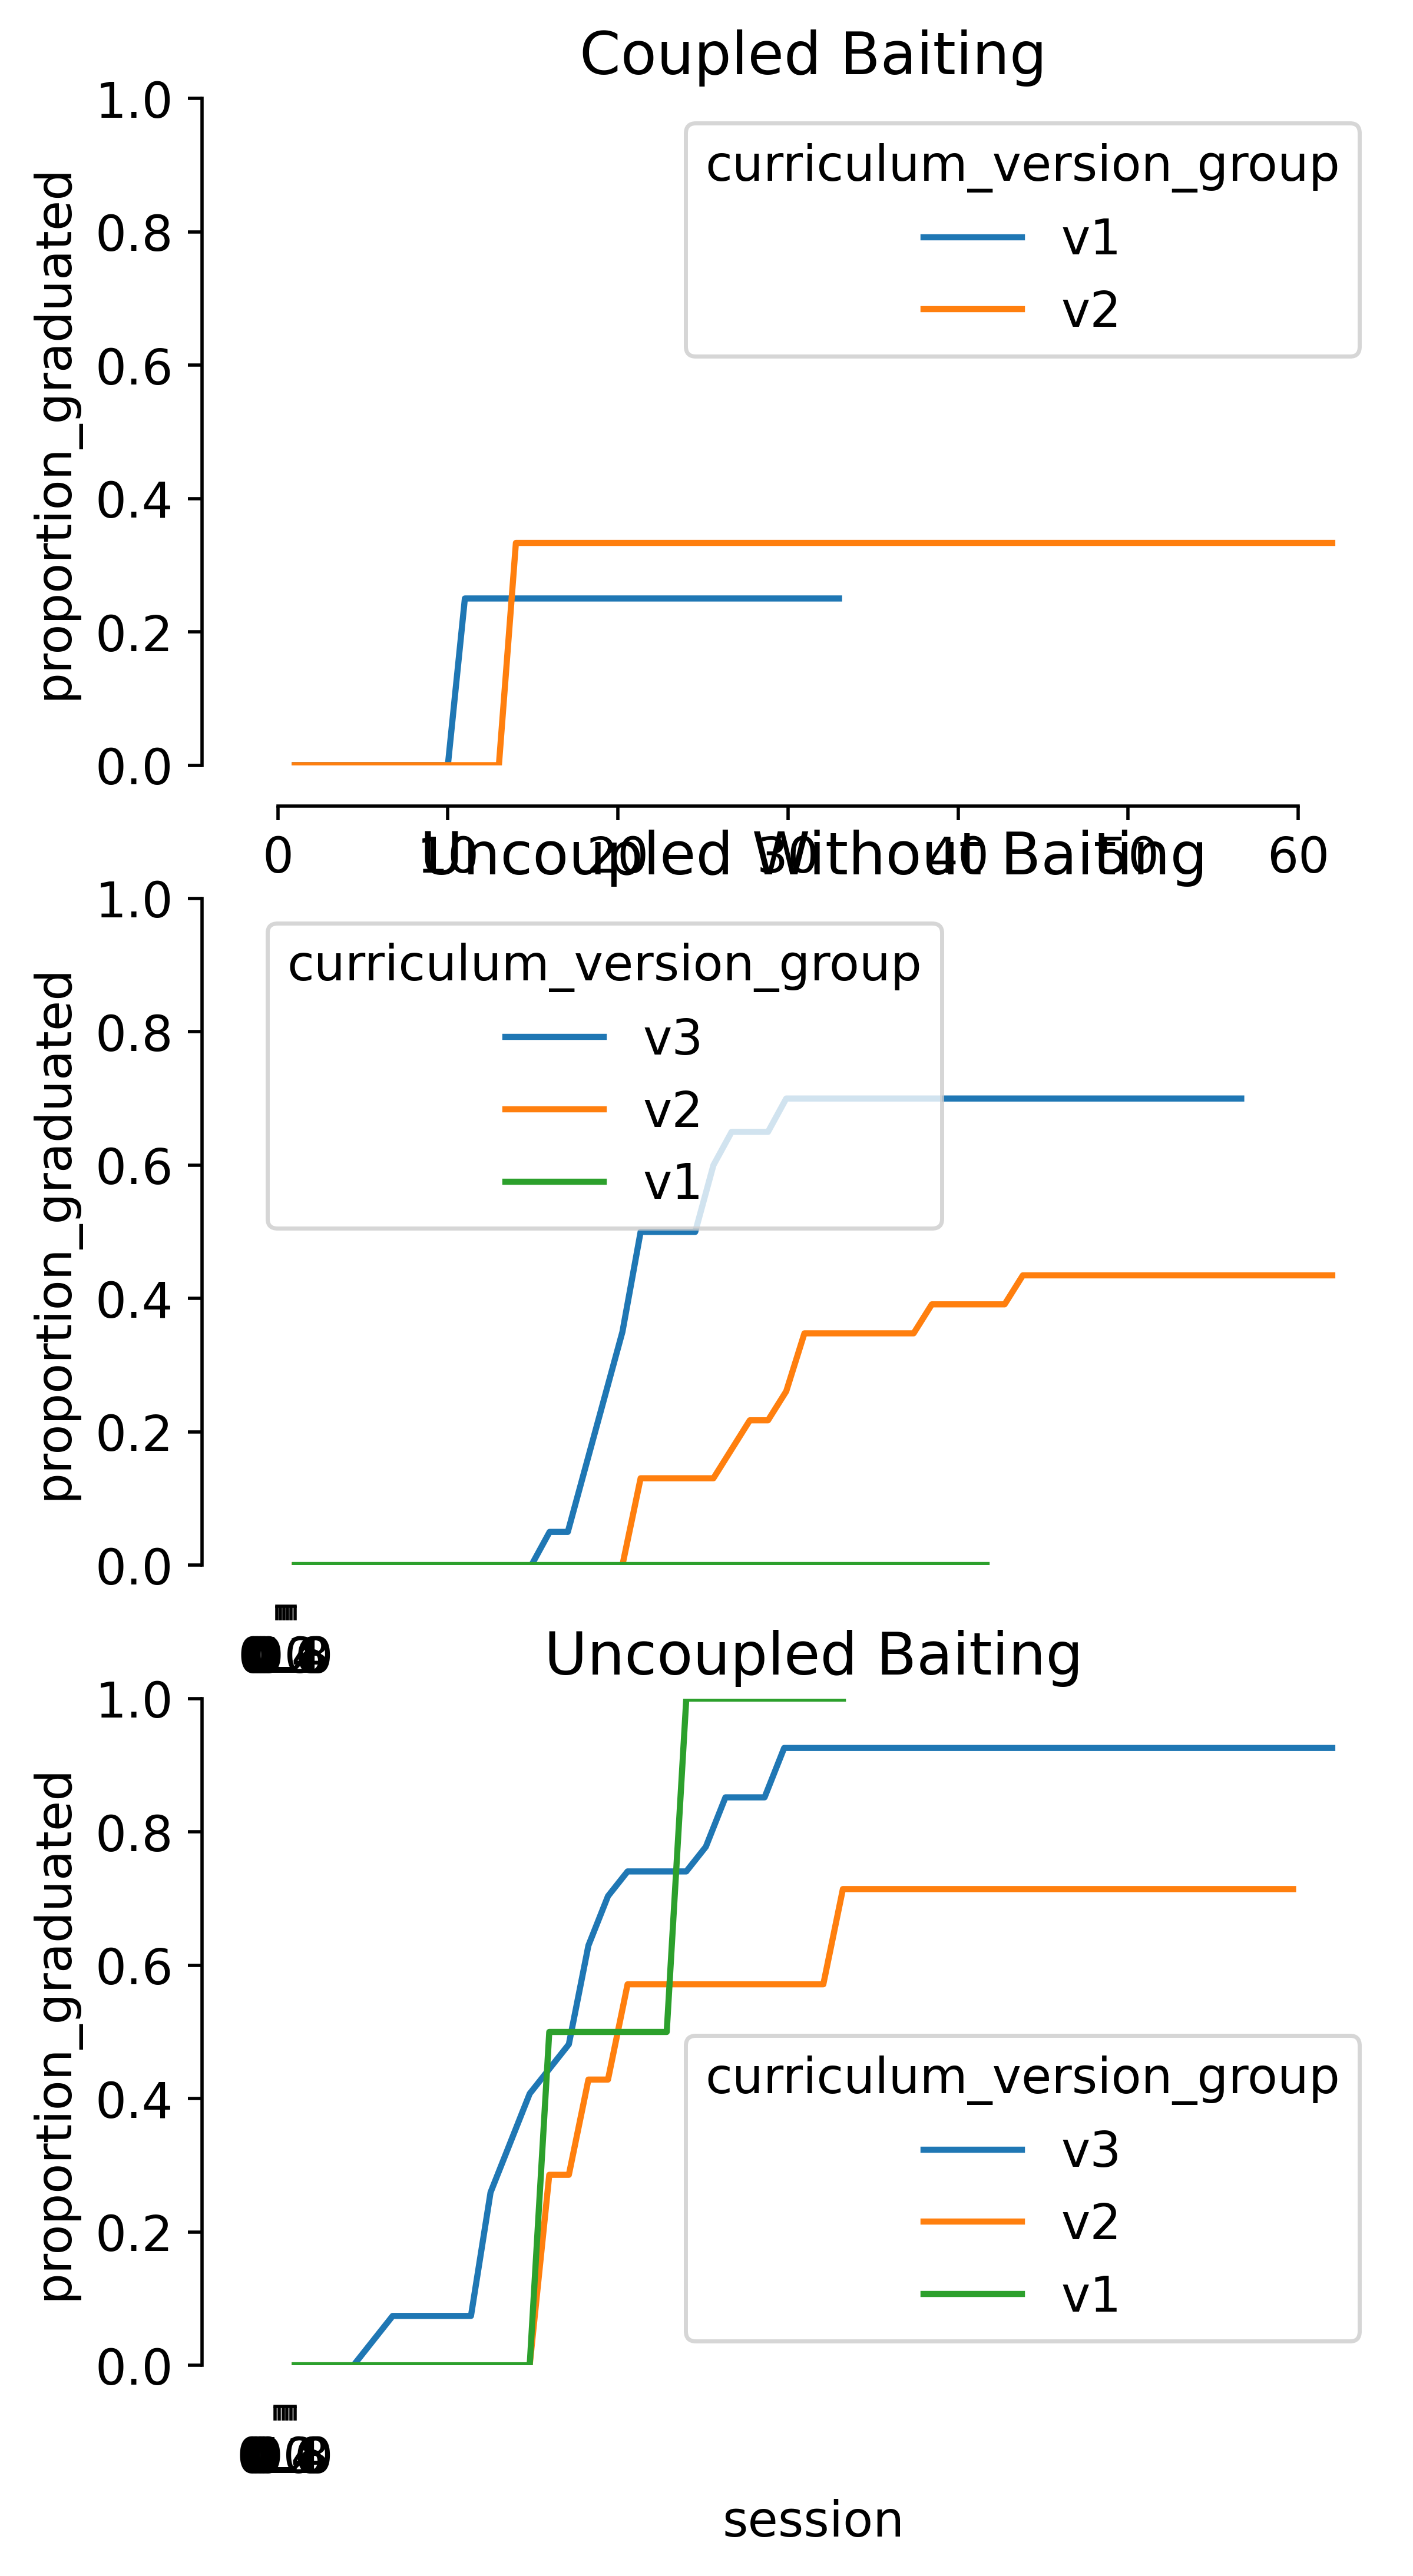

In [49]:
min_dropout_session = 25 # Minimum number of sessions to consider a mouse as dropped out

df_to_plot = df_curriculum_on_only.groupby("subject_id").filter(
        lambda x: x["session"].max() >= min_dropout_session
        )  # Those who have at least 25 sessions

fig, axes = plt.subplots(3, 1, figsize=(5, 10), dpi=500)

for i, curriculum in enumerate(curriculum_name_order):
    df_cumulative_graduation = compute_cumulative_graduation_rate(
        df_to_plot.query("curriculum_name == @curriculum")
    )
    
    ax = axes[i]
    sns.lineplot(
        data=df_cumulative_graduation,
        x="session",
        y="proportion_graduated",
        hue="curriculum_version_group",
        ax=ax,
    )
    ax.set(ylim=(0, 1))
    ax.set_title(curriculum)
    sns.despine(offset=10, trim=True)

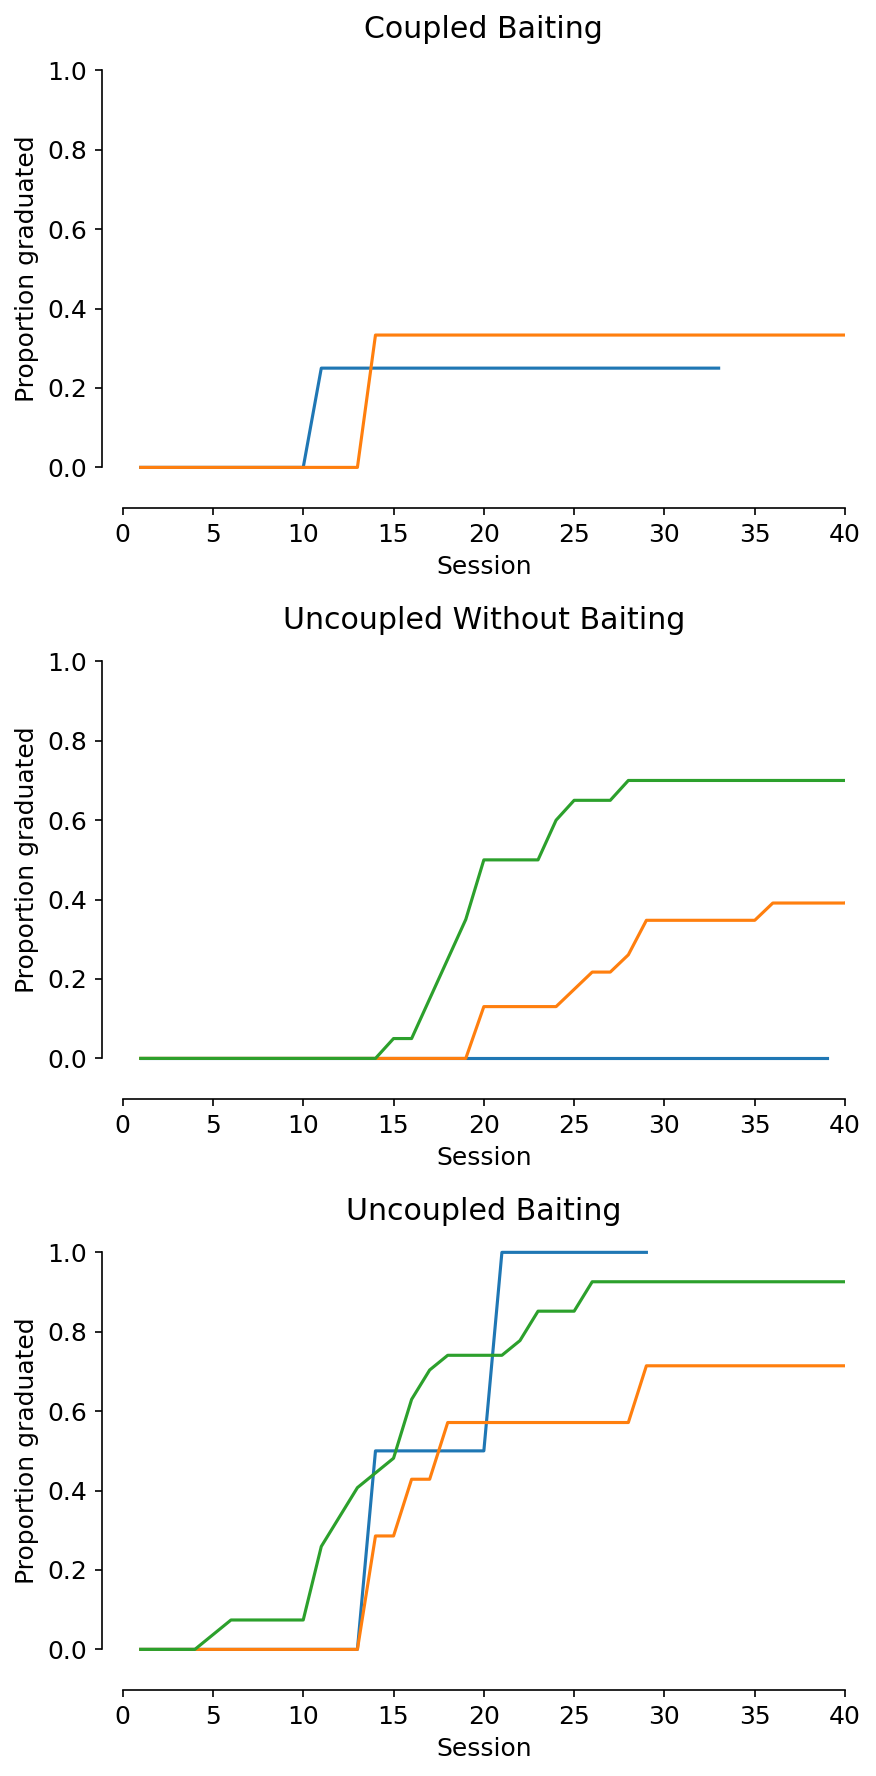

In [50]:
min_dropout_session = 25 # Minimum number of sessions to consider a mouse as dropped out

df_to_plot = df_curriculum_on_only.groupby("subject_id").filter(
        lambda x: x["session"].max() >= min_dropout_session
        )  # Those who have at least 25 sessions

fig, axes = plt.subplots(3, 1, figsize=(6, 12), dpi=150)

for i, curriculum in enumerate(curriculum_name_order):
    ax = axes[i]
    df_cumulative_graduation = compute_cumulative_graduation_rate(
        df_to_plot.query("curriculum_name == @curriculum")
    )
    
    for j, ver in enumerate(ver_order):
        this_df = df_cumulative_graduation.query("curriculum_version_group == @ver")
        if this_df.empty:
            continue
    
        ax.plot(
            this_df["session"],
            this_df["proportion_graduated"],
        )
    ax.set(ylim=(-0.05, 1.05), xlim=(0, 40), ylabel="Proportion graduated", xlabel="Session")
    ax.set_title(curriculum)
    
sns.despine(offset=10, trim=True)
fig.tight_layout()